# Visualising time series with Statistical API

## Introduction to Statistical API

In the Process API examples, we have seen how to obtain satellite imagery. [Statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html) can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Python Library Imports

In [1]:
# Utilities
import getpass
import warnings
from typing import (
    Optional,
    Tuple,
    Any
)
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress specific warnings

# Data Manipulation
import pandas as pd
import geopandas as gpd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import contextily as cx

# Sentinel Hub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    CRS,
    Geometry,
    parse_time
)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
# Helper Utility Functions

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [3]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [4]:
config = SHConfig("cdse")

### Creating a field of interest

Firstly, we will define some fields of interest in France for the first few examples. We will use the [Sentinel-2 L2A](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S2L2A.html) data collection in the first examples though.

In [5]:
fields="""{
"type": "FeatureCollection",
"name": "french_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018730388794967, 48.31900866284024 ], [ 3.02416040226223, 48.319921908340902 ], [ 3.024582971403651, 48.318306155176266 ], [ 3.019491013249525, 48.317392880750582 ], [ 3.018730388794967, 48.31900866284024 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.014150362764628, 48.311958271928731 ], [ 3.012550141917608, 48.312082666515273 ], [ 3.009640649468477, 48.312428205442302 ], [ 3.009328918134642, 48.314653420076148 ], [ 3.015334941833203, 48.314529031756756 ], [ 3.015272595566436, 48.314072938657887 ], [ 3.01566745525596, 48.313603020291822 ], [ 3.016311700012554, 48.313091633623024 ], [ 3.016914380591302, 48.312911956009131 ], [ 3.017142983569447, 48.312566420357946 ], [ 3.016789688057767, 48.312372919371228 ], [ 3.015064774677212, 48.312013558449088 ], [ 3.014150362764628, 48.311958271928731 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018867896950004, 48.310686665428022 ], [ 3.016685777613156, 48.30872390623729 ], [ 3.013339861296657, 48.311115145071334 ], [ 3.014025670231094, 48.311875342035918 ], [ 3.015542762722426, 48.311972093564449 ], [ 3.016290917923631, 48.311225719879126 ], [ 3.017371586547594, 48.311502155850299 ], [ 3.018285998460177, 48.310838707003604 ], [ 3.018867896950004, 48.310686665428022 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.991995616868946, 48.313513412817962 ], [ 2.996665005881652, 48.314890448089699 ], [ 2.997045318108931, 48.314595372231501 ], [ 2.997953841762987, 48.314258140589665 ], [ 2.998756723131687, 48.313710134417846 ], [ 2.993073168179571, 48.312094184517214 ], [ 2.991995616868946, 48.313513412817962 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.005412187109072, 48.316379852565653 ], [ 3.005496700937356, 48.313583670619266 ], [ 3.003341598316108, 48.314412705368852 ], [ 3.002242918548413, 48.314763987216573 ], [ 3.001313266437286, 48.314862345700547 ], [ 3.000785055010509, 48.315059062099621 ], [ 3.004165608141879, 48.315958327408346 ], [ 3.005412187109072, 48.316379852565653 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.994681699890837, 48.308712715603669 ], [ 2.994697906481011, 48.308691157048038 ], [ 2.994924798743444, 48.308259984022804 ], [ 2.994973418513966, 48.307559320087115 ], [ 2.991083836872255, 48.307483863397216 ], [ 2.990630052347389, 48.30864803990945 ], [ 2.994681699890837, 48.308712715603669 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.001245368911225, 48.311019428435152 ], [ 2.994519633989099, 48.308971417560947 ], [ 2.993352759496587, 48.310577496200999 ], [ 3.000175733959753, 48.312539214953759 ], [ 3.000775377796184, 48.31147213553583 ], [ 3.001002270058617, 48.311213446255813 ], [ 3.001245368911225, 48.311019428435152 ] ] ] ] } }
]
}
"""

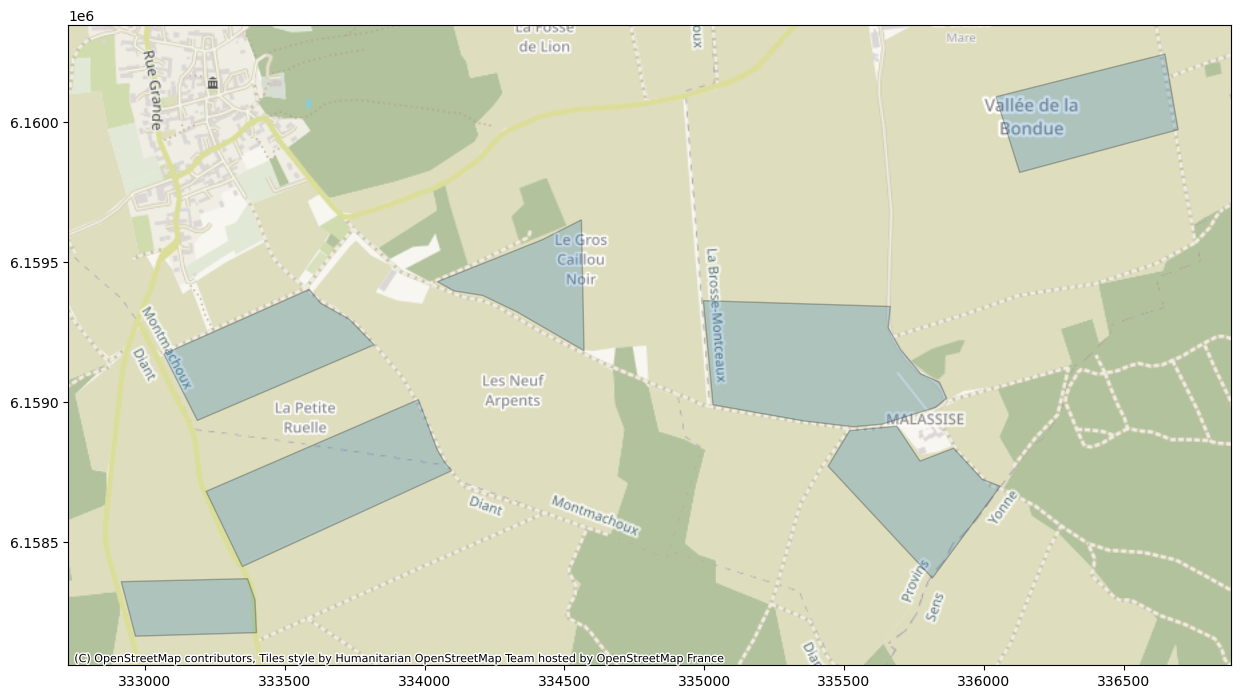

In [6]:
fields_gdf = gpd.read_file(fields)
fields_gdf["area"] = fields_gdf.geometry.area

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = fields_gdf_wm.plot(alpha=0.25, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

## 1. How to create an NDVI time series for a field of interest

### The Evalscript

In this evalscript, we are calculating NDVI. Let's remind ourselves that evalscripts operate slightly differently with Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [7]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. The aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 

**NOTE:**
If `time_interval` is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

In [8]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z'),
        aggregation_interval='P5D',
        resolution=(0.0001,0.0001),        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()
#response1 # try uncommenting this line to see what the raw JSON response looks like. 

### Manipulation and Visualisation of our Output

However, as it is clear to see, our response is not that useful in `json` format. It's difficult to read from a human perspective. So, let's transform it into a `pandas` dataframe. To help us achieve this, let's call some helper functions. 

In [9]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2023-01-01,-0.007692,0.049558,0.024351,0.009588
0,2023-01-06,-0.003138,0.065646,0.027728,0.010749
0,2023-01-11,0.145329,0.751540,0.273972,0.065011
0,2023-01-16,0.002421,0.167092,0.078531,0.023692
0,2023-01-21,-0.009227,0.025436,0.005719,0.005307
...,...,...,...,...,...
0,2023-12-02,0.039316,0.439589,0.176294,0.100129
0,2023-12-07,0.148073,0.212240,0.183754,0.010672
0,2023-12-12,0.049980,0.186453,0.089945,0.024388
0,2023-12-17,0.011880,0.047857,0.031084,0.005790


We can take this another step further, and display the data in a time series using the Matplotlib python library:

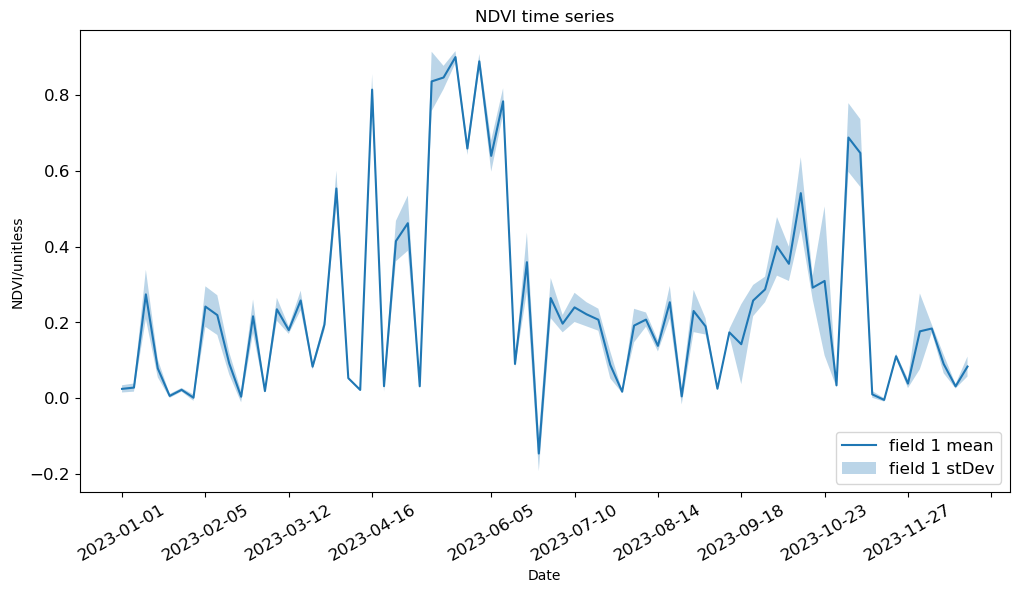

In [10]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Extract data
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['ndvi_mean']
ndvi_std_field1 = result_df1['ndvi_stDev']

# Plot mean and standard deviation
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))

# Set labels and title
ax_stat.set(xlabel='Date', ylabel='NDVI/unitless', title='NDVI time series')

# Set legend
ax_stat.legend(loc='lower right', prop={'size': 12});

## 2. Removing cloudy acquisitions from your NDVI time series

However, not filtering out the cloudy acquisitions means we have a very noisy time series which is not reflective of the NDVI values on the land surface. In the second example, we will filter out the cloudiest acquisitions.

### The Evalscript

This stays the same as the previous example, so we do not need to redefine it here.

### The Request Body

The request is only slightly adjusted from previously. We have added an additional argument: 

```
other_args={"dataFilter": {"maxCloudCoverage": 10}},
```
This will filter our data and means we will only use Sentinel-2 data where the cloud cover percentage of the scene was below 10%            

In [11]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z'),
        aggregation_interval='P5D',
        resolution=(0.0001,0.0001),        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},            
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [12]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2023-02-10,0.172257,0.661914,0.219200,0.052452
0,2023-04-01,0.408534,0.810960,0.551256,0.047116
0,2023-05-21,0.731556,0.919490,0.900720,0.015818
0,2023-05-31,0.675090,0.912911,0.889504,0.019571
0,2023-06-10,0.548549,0.858288,0.783846,0.034665
0,2023-06-20,0.169877,0.710462,0.350656,0.081603
0,2023-08-29,0.182271,0.564184,0.227733,0.055634
0,2023-09-03,0.157056,0.344126,0.189521,0.021609
0,2023-10-03,0.192443,0.639291,0.400864,0.077397


We can take this another step further, and display the data in a time series using the Matplotlib python library:

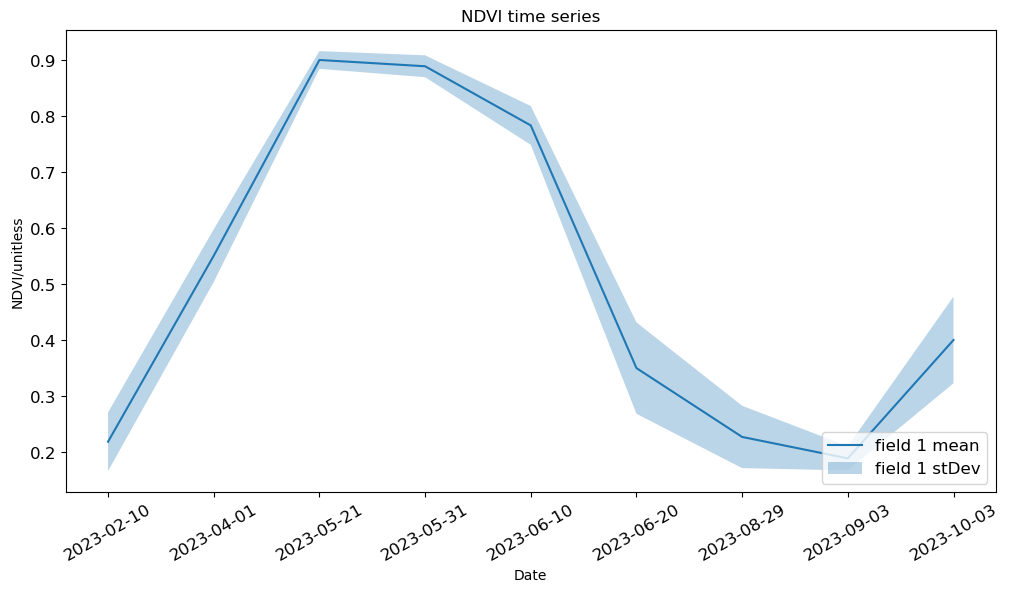

In [13]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Extract data
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['ndvi_mean']
ndvi_std_field1 = result_df1['ndvi_stDev']

# Plot mean and standard deviation
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))

# Set labels and title
ax_stat.set(xlabel='Date', ylabel='NDVI/unitless', title='NDVI time series')

# Set legend
ax_stat.legend(loc='lower right', prop={'size': 12});

We now have a much smoother NDVI time series. We have less data points now though. In your own time, try experimenting with the cloud coverage filter and see if you can find the sweet point between the number of data points and smoothness of the time series plot.

We can take this another step further, and display the data in a time series using the Matplotlib python library:

## 3. Outputting multiple outputs from a single statistical API request

It is also possible to define multiple outputs from your evalscript. In this example, we generate NDVI and NDWI time series in the same request and then plot them on the same plot.

### The Evalscript

In [14]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B03",
          "B04",
          "B08",
          "dataMask",
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "ndwi",
        bands: 1
      },  
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function evaluatePixel(samples) {


    return {
      ndvi: [index(samples.B08, samples.B04)],
      ndwi: [index(samples.B08, samples.B03)],
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

In [ ]:
fields_gdf = gpd.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-05-01T00:00:00Z', '2023-04-30T23:59:59Z'),
        aggregation_interval='P5D',
        resolution=(0.0001, 0.0001),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [16]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev,ndwi_min,ndwi_max,ndwi_mean,ndwi_stDev
0,2022-05-31,0.633747,0.907918,0.870227,0.040477,0.598237,0.845028,0.803420,0.039517
0,2022-06-15,0.277860,0.653310,0.541391,0.091683,0.427330,0.633634,0.553209,0.048714
0,2022-07-05,0.152140,0.501290,0.180820,0.024099,0.304145,0.549590,0.334873,0.019079
0,2022-07-15,0.163967,0.454272,0.193624,0.020120,0.333042,0.511737,0.368283,0.014226
0,2022-07-20,0.146375,0.621138,0.203857,0.060532,0.304659,0.560861,0.351143,0.032154
0,2022-07-30,0.140717,0.681784,0.192840,0.076933,0.310539,0.610256,0.354988,0.043787
0,2022-08-04,0.159547,0.795153,0.217143,0.099402,0.313856,0.711118,0.365349,0.060967
0,2022-08-09,0.175632,0.756163,0.248055,0.087533,0.335526,0.681979,0.384557,0.051333
0,2022-09-18,0.411577,0.874031,0.838798,0.047243,0.484916,0.756847,0.715037,0.023676
0,2022-10-28,0.227355,0.863014,0.795306,0.133351,0.352280,0.757861,0.709703,0.079934


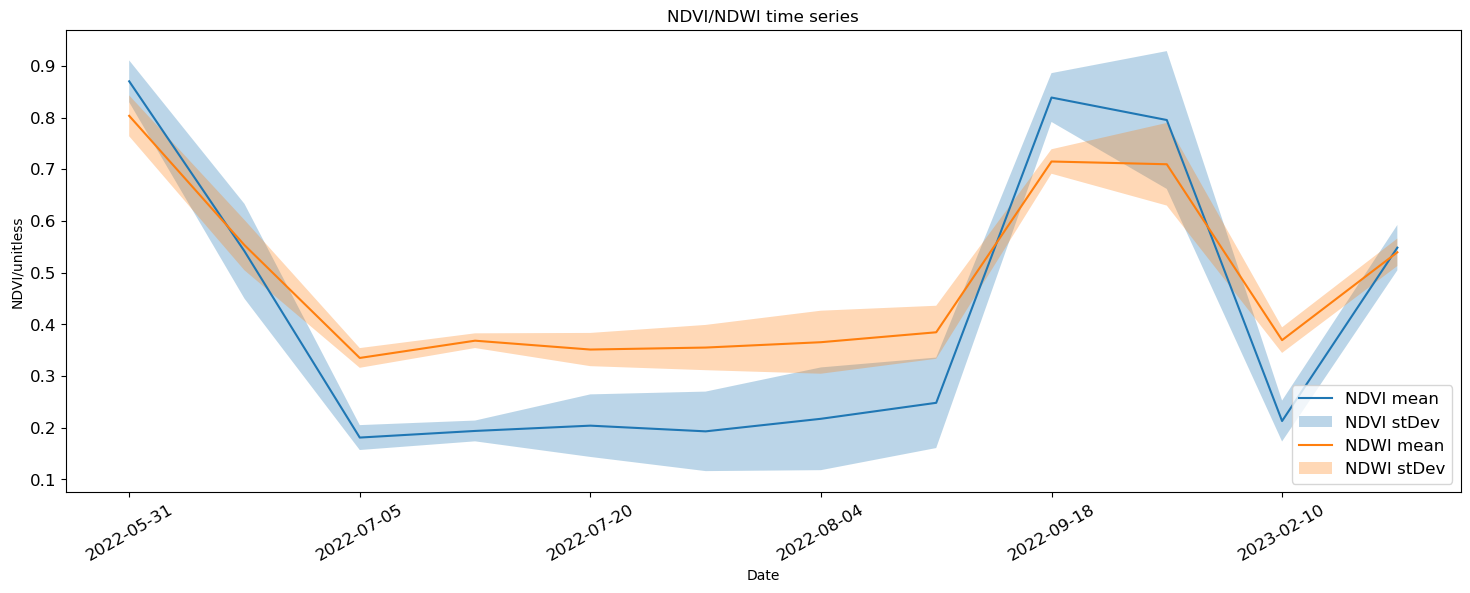

In [17]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))

# Extract data
t = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]

# Plot NDVI mean and standard deviation
ax_stat.plot(t, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)

# Plot NDWI mean and standard deviation
ax_stat.plot(t, ndwi_mean_field1, label="NDWI mean")
ax_stat.fill_between(
    t,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="NDWI stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI/NDWI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12})

plt.show()

## Side Quest! Fine tuning the Color Palettes in Matplotlib and even the theme!

As we start to make more complex plots we may want to make them more colourful or if it is for an academic publication less colourful. With Matplotlib, there is the flexibility to either change the colours of different time series or even use a completely different theme. So let's get to it! We'll use the previous example as our test dummy:

### Changing colours:

This one is easy, we have two functions for each of our dataseries called `ax_stat.plot()` and `ax_stat.fill_between()`. We can add an extra input to the function called `color` and after the `=` sign you can then type in your colour as a string. You can find these colours by visiting this [page](https://matplotlib.org/stable/gallery/color/named_colors.html). In the example below we have changed the NDVI data series to be green and the NDWI data series to be blue. This makes more sense than in the previous visualisation. In addition, in the `ax_stat.fill_between()` function there is an `alpha` input; this defines how seethrough the standard deviation data series is.

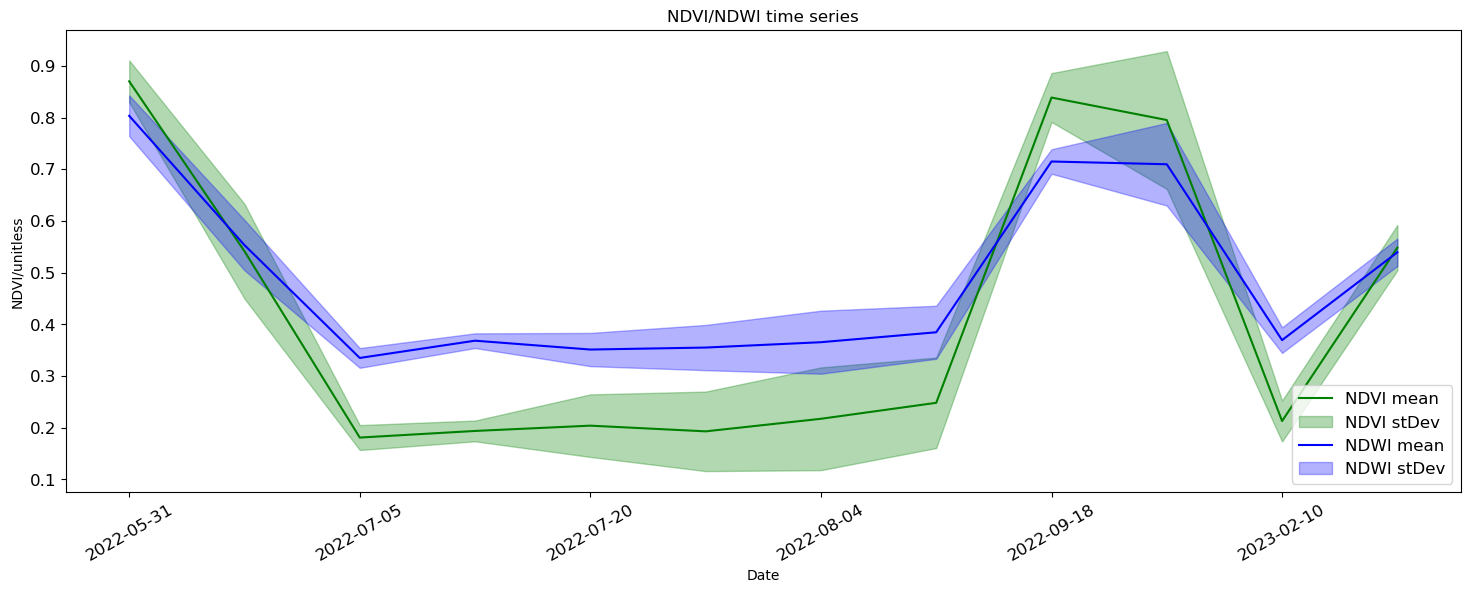

In [18]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))

# Extract data
t = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]

# Plot NDVI mean and standard deviation
ax_stat.plot(t, ndvi_mean_field1, label="NDVI mean", color="green")
ax_stat.fill_between(
    t,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    color="green",
    alpha=0.3,
    label="NDVI stDev",
)

# Plot NDWI mean and standard deviation
ax_stat.plot(t, ndwi_mean_field1, label="NDWI mean", color="blue")
ax_stat.fill_between(
    t,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    color="blue",
    alpha=0.3,
    label="NDWI stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI/NDWI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12})

plt.show()

### Changing the style of your plots

You can also change the theme of your plots too using some predefined styles found as part of the python library. You can use the following function to return back all the different styles available to you. You can preview those styles on this [reference page](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).

In [19]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

Once you have decided on the style you want you can the below function to implement it. Let's use the `bmh` theme for the rest of the notebook.

In [20]:
plt.style.use('bmh')

We can plot the time series again with the new style:

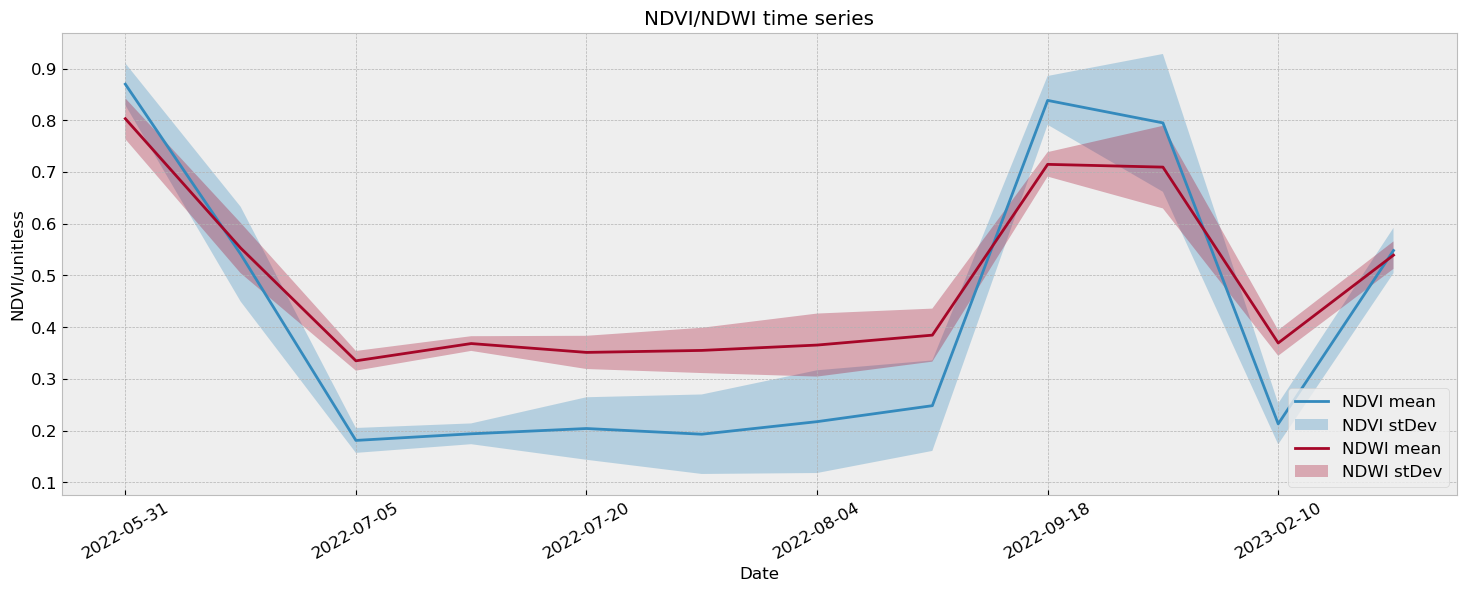

In [21]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))

# Extract data
t = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]

# Plot NDVI mean and standard deviation
ax_stat.plot(t, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)

# Plot NDWI mean and standard deviation
ax_stat.plot(t, ndwi_mean_field1, label="NDWI mean")
ax_stat.fill_between(
    t,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="NDWI stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI/NDWI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12})

plt.show()

## 5. Making Multiple Requests to compare several fields of interest

Now that we have learnt how to plot the data for the first field, let's take this another step forward and compare the NDVI time series of the first field with the second field. We will now run the same request for our second field and then transform the response into a second Pandas dataframe. In addition to making multiple requests, we will also use the Planet Fusion dataset to generate our NDVI time series statistics. 

### The Evalscript

In [22]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

In [23]:
yearly_time_interval = "2021-01-01", "2022-01-01"

aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=yearly_time_interval,
    aggregation_interval="P5D",
    resolution=(0.0001, 0.0001),
)

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
    maxcc=0.1,
)

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [24]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 36.2 ms, sys: 12.8 ms, total: 49 ms
Wall time: 1.65 s


7

### Manipulation and Visualisation of our Output

In [25]:
ndvi_dfs = [
    stats_to_df(polygon_stats).assign(id=id) 
    for polygon_stats, id in zip(ndvi_stats, fields_gdf["id"].values)
]

ndvi_df = pd.concat(ndvi_dfs)

ndvi_df

,interval_from,interval_to,ndvi_B0_min,ndvi_B0_max,ndvi_B0_mean,ndvi_B0_stDev,ndvi_B0_sampleCount,ndvi_B0_noDataCount,id
0,2021-01-06,2021-01-11,-0.029672,0.081506,0.022245,0.015055,1475,498,1
1,2021-02-20,2021-02-25,0.194847,0.406674,0.270289,0.026377,1475,498,1
2,2021-02-25,2021-03-02,0.183252,0.514038,0.292171,0.039446,1475,498,1
3,2021-03-02,2021-03-07,0.178444,0.546235,0.302815,0.047463,1475,498,1
4,2021-03-27,2021-04-01,0.189807,0.601798,0.374115,0.075405,1475,498,1
...,...,...,...,...,...,...,...,...,...
9,2021-09-18,2021-09-23,0.190671,0.639500,0.313135,0.059996,2844,1458,7
10,2021-10-18,2021-10-23,0.237476,0.841291,0.587628,0.108807,2844,1458,7
11,2021-10-23,2021-10-28,0.208033,0.810966,0.576897,0.130640,2844,1458,7
12,2021-12-17,2021-12-22,0.154286,0.682939,0.236726,0.075569,2844,1458,7


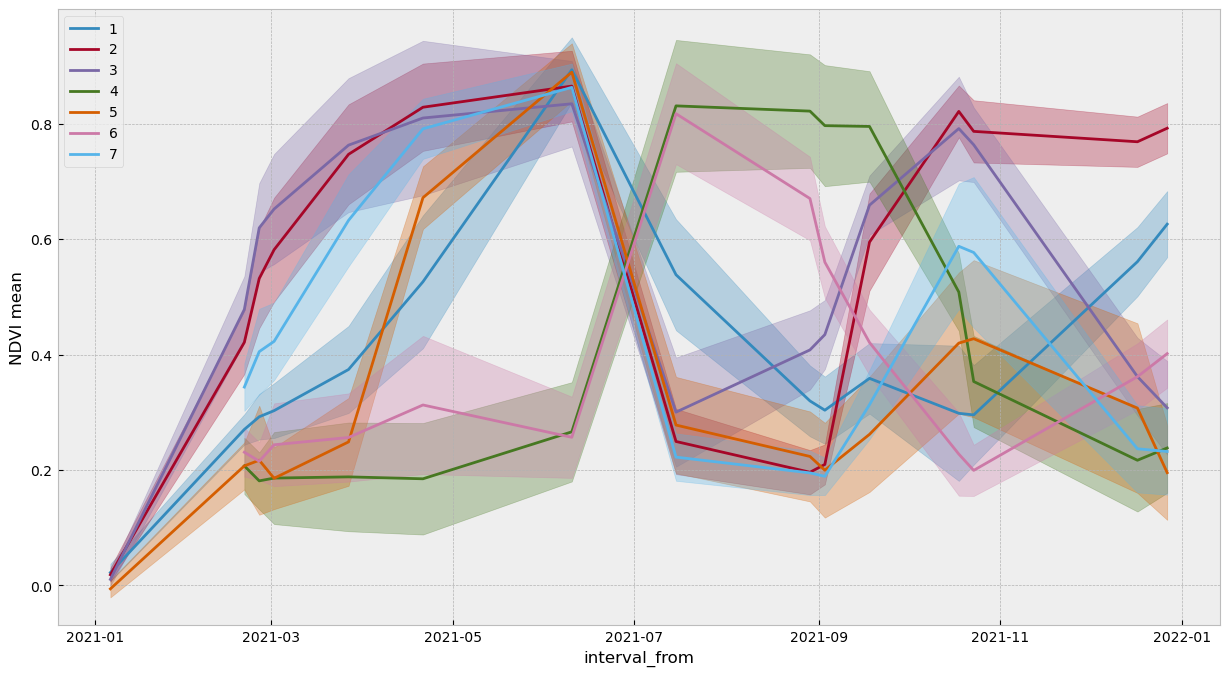

In [26]:
# Create a figure and axis with specified size
fig, ax = plt.subplots(figsize=(15, 8))

# Set the y-axis label
ax.set_ylabel("NDVI mean")

# Extract the 'id' values from the GeoDataFrame
ids = fields_gdf["id"].values

# Iterate over each 'id' and its index
for idx, id in enumerate(ids):
    # Filter the DataFrame for the current 'id'
    series = ndvi_df[ndvi_df["id"] == id]

    # Plot the NDVI mean for the current series
    series.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color=f"C{idx}", label=id)

    # Fill the area between the mean ± standard deviation
    ax.fill_between(
        series["interval_from"],
        series["ndvi_B0_mean"] - series["ndvi_B0_stDev"],
        series["ndvi_B0_mean"] + series["ndvi_B0_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    )

# Display the plot
plt.show()

## Summary

Congratulations on completing the notebook! From this notebook you should have learned how to:

- Create an NDVI time series for a field of interest.
- Remove cloud acquisitions from your NDVI time series.
- Create custom datamasks to remove cloud pixels.
- Output multiple outputs from a single request.
- Customise the color palettes and themes of your plots.
- Make multiple requests to compare several fields of interest.

After running these examples you are now ready to go out there and start to really analyse your data whether from Statistical or Processing APIs! If you wish you can continue to more advanced examples in the [Advanced_Statistical_Visualisations_with_Statistical_API.ipynb](Advanced_Statistical_Visualisations_with_Statistical_API.ipynb) notebook.